## Examen Final: Clasificación de Mortalidad Hospitalaria Machine Learning Supervisado

#### Descripción del Problema
Predecir la mortalidad hospitalaria de pacientes críticamente enfermos es importante debido a la creciente preocupacióon sobre la pérdida de control de los pacientes hacia el final de la vida.
Una prediccióon acertada permite tomar decisiones anticipadas para reducir la frecuencia de un proceso de muerte mecánico, doloroso y prolongado.
El objetivo del examen es dise˜nar un clasificador que permita predecir la mortalidad de estos pacientes a partir de varias características fisiológicas, demográficas y de severidad de la enfermedad.

#### 1. Importacion de librerias a utilizar

In [1]:
import pandas as pd
import numpy as np
from random import random, seed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_validate, cross_val_predict, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score , average_precision_score, f1_score, classification_report, precision_recall_curve, auc, recall_score, precision_score,roc_auc_score, precision_recall_curve, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Semilla global para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#### 2. Carga de datos

In [3]:
data = pd.read_csv('data/data_train.csv')
data.head()

,Unnamed: 0,age,sex,dzgroup,dzclass,num.co,scoma,avtisst,race,sps,...,dnr,dnrday,meanbp,hrt,resp,temp,crea,sod,adlsc,hospdead
0,0,62.84998,male,Lung Cancer,Cancer,0,0.0,7.000000,other,33.898438,...,no dnr,5.0,97.0,69.0,22.0,36.00000,1.199951,141.0,7.0,0
1,1,60.33899,female,Cirrhosis,COPD/CHF/Cirrhosis,2,44.0,29.000000,white,52.695312,...,NaN,NaN,43.0,112.0,34.0,34.59375,5.500000,132.0,1.0,1
2,2,52.74698,female,Cirrhosis,COPD/CHF/Cirrhosis,2,0.0,13.000000,white,20.500000,...,no dnr,17.0,70.0,88.0,28.0,37.39844,2.000000,134.0,0.0,0
3,3,42.38498,female,Lung Cancer,Cancer,2,0.0,7.000000,white,20.097656,...,no dnr,3.0,75.0,88.0,32.0,35.00000,0.799927,139.0,0.0,0
4,4,79.88495,female,ARF/MOSF w/Sepsis,ARF/MOSF,1,26.0,18.666656,white,23.500000,...,no dnr,16.0,59.0,112.0,20.0,37.89844,0.799927,143.0,2.0,0


#### 3. Analisis exploratorio

Hay un total de 27 columnas y 9105 filas. Analizando los tipos de datos se observa que hay datos numericos y categoricos. 


In [4]:
#Ver los tipos de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9105 entries, 0 to 9104
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9105 non-null   int64  
 1   age         9105 non-null   float64
 2   sex         9105 non-null   object 
 3   dzgroup     9105 non-null   object 
 4   dzclass     9105 non-null   object 
 5   num.co      9105 non-null   int64  
 6   scoma       9104 non-null   float64
 7   avtisst     9023 non-null   float64
 8   race        9063 non-null   object 
 9   sps         9104 non-null   float64
 10  aps         9104 non-null   float64
 11  surv2m      9104 non-null   float64
 12  surv6m      9104 non-null   float64
 13  hday        9105 non-null   int64  
 14  diabetes    9105 non-null   int64  
 15  dementia    9105 non-null   int64  
 16  ca          9105 non-null   object 
 17  dnr         9075 non-null   object 
 18  dnrday      9075 non-null   float64
 19  meanbp      9104 non-null  

Hay una columna con nombre Unnamed: 0. Hay que averiguar con el experto que significa

In [5]:
data.describe()

,Unnamed: 0,age,num.co,scoma,avtisst,sps,aps,surv2m,surv6m,hday,...,dementia,dnrday,meanbp,hrt,resp,temp,crea,sod,adlsc,hospdead
count,9105.000000,9105.000000,9105.000000,9104.000000,9023.000000,9104.000000,9104.000000,9104.000000,9104.000000,9105.000000,...,9105.000000,9075.000000,9104.000000,9104.000000,9104.000000,9104.000000,9038.000000,9104.000000,9105.000000,9105.000000
mean,4552.000000,62.650823,1.868644,12.058546,22.610928,25.525872,37.597979,0.635870,0.520096,4.400000,...,0.032510,14.582590,84.546408,97.156711,23.330294,37.103341,1.770961,137.568541,1.888272,0.259198
std,2628.531434,15.593710,1.344409,24.636694,13.233248,9.899377,19.903852,0.248175,0.253343,9.126811,...,0.177359,19.944216,27.687692,31.559292,9.573801,1.251796,1.686041,6.029326,2.003763,0.438219
min,0.000000,18.041990,0.000000,0.000000,1.000000,0.199982,0.000000,0.000000,0.000000,1.000000,...,0.000000,-88.000000,0.000000,0.000000,0.000000,31.699220,0.099991,110.000000,0.000000,0.000000
25%,2276.000000,52.797000,1.000000,0.000000,12.000000,19.000000,23.000000,0.507690,0.342957,1.000000,...,0.000000,4.000000,63.000000,72.000000,18.000000,36.195310,0.899902,134.000000,0.000000,0.000000
50%,4552.000000,64.856990,2.000000,0.000000,19.500000,23.898438,34.000000,0.715942,0.574951,1.000000,...,0.000000,9.000000,77.000000,100.000000,24.000000,36.695310,1.199951,137.000000,1.000000,0.000000
75%,6828.000000,73.998960,3.000000,9.000000,31.666656,30.199219,49.000000,0.825928,0.725952,3.000000,...,0.000000,17.000000,107.000000,120.000000,28.000000,38.195310,1.899902,141.000000,3.000000,1.000000
max,9104.000000,101.847960,9.000000,100.000000,83.000000,99.187500,143.000000,0.969971,0.947998,148.000000,...,1.000000,285.000000,195.000000,300.000000,90.000000,41.695310,21.500000,181.000000,7.073242,1.000000


Inspeccionar datos duplicados y datos faltantes

In [6]:
print(" datos duplicados ")
data.duplicated().sum()

 datos duplicados 


np.int64(0)

In [7]:
print(" datos faltantes ")      
data.isna().sum()

 datos faltantes 


Unnamed: 0     0
age            0
sex            0
dzgroup        0
dzclass        0
num.co         0
scoma          1
avtisst       82
race          42
sps            1
aps            1
surv2m         1
surv6m         1
hday           0
diabetes       0
dementia       0
ca             0
dnr           30
dnrday        30
meanbp         1
hrt            1
resp           1
temp           1
crea          67
sod            1
adlsc          0
hospdead       0
dtype: int64

In [8]:
# Porcentaje de datos faltantes
features_nan = [feature for feature in data.columns if data[feature].isnull().sum() > 0]
for feature in features_nan:
    print("La variable {} tiene {} % datos faltantes".format(feature, np.round(data[feature].isnull().sum()/len(data)*100,4)))

La variable scoma tiene 0.011 % datos faltantes
La variable avtisst tiene 0.9006 % datos faltantes
La variable race tiene 0.4613 % datos faltantes
La variable sps tiene 0.011 % datos faltantes
La variable aps tiene 0.011 % datos faltantes
La variable surv2m tiene 0.011 % datos faltantes
La variable surv6m tiene 0.011 % datos faltantes
La variable dnr tiene 0.3295 % datos faltantes
La variable dnrday tiene 0.3295 % datos faltantes
La variable meanbp tiene 0.011 % datos faltantes
La variable hrt tiene 0.011 % datos faltantes
La variable resp tiene 0.011 % datos faltantes
La variable temp tiene 0.011 % datos faltantes
La variable crea tiene 0.7359 % datos faltantes
La variable sod tiene 0.011 % datos faltantes


No hay datos duplicados 
Hay datos faltantes en varias columnas pero el porcentaje es pequeño

Analizar la distribucion de la variable objetivo `hospdead` para saber si el problema esta desbalanceado.

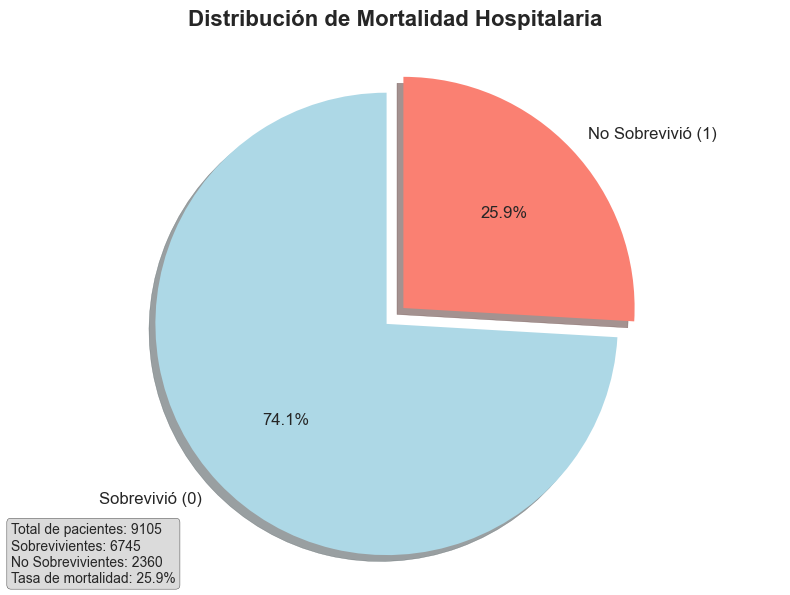

In [9]:
# Análisis de la variable objetivo: hospdead
# Crear un gráfico de pie más detallado
plt.figure(figsize=(8, 6))

# Obtener los valores y etiquetas
values = data['hospdead'].value_counts()
labels = ['Sobrevivió (0)', 'No Sobrevivió (1)']
colors = ['lightblue', 'salmon']

# Crear el gráfico de pie con más detalles
plt.pie(values, 
        labels=labels, 
        colors=colors,
        autopct='%1.1f%%',  # Mostrar porcentajes
        startangle=90,      # Comenzar desde arriba
        explode=(0, 0.1),   # Separar ligeramente el segmento de muerte
        shadow=True,        # Agregar sombra
        textprops={'fontsize': 12})

plt.title('Distribución de Mortalidad Hospitalaria', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')

# Agregar información adicional
total_patients = len(data)
deaths = values[1]
survivors = values[0]
mortality_rate = (deaths / total_patients) * 100

plt.figtext(0.02, 0.02, f'Total de pacientes: {total_patients}\nSobrevivientes: {survivors}\nNo Sobrevivientes: {deaths}\nTasa de mortalidad: {mortality_rate:.1f}%', 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.show()

Se puede observar que la clases estan desbalanceadas hacia la clase negativa

La caracteristica 'Unnamed: 0' es un indice que no aporta varianza al problema. Se decide quitarla

In [10]:
# agrupar por los valores de 'Unnamed: 0'
print(data['Unnamed: 0'].nunique())
data = data.drop(columns='Unnamed: 0', axis=1)

9105


In [11]:
numeric_features = data.select_dtypes(include=[np.number])
categorical_features = data.select_dtypes(include=['object', 'category'])

#numeric_features_col = data.select_dtypes(include=[np.number]).columns.tolist()
#categorical_features_col = data.select_dtypes(include=['object', 'category']).columns.tolist()

#sin target categorical_features_sn_target = categorical_features.drop(columns=['hospdead'])
numeric_features_sn_target = numeric_features.drop(columns=['hospdead'])

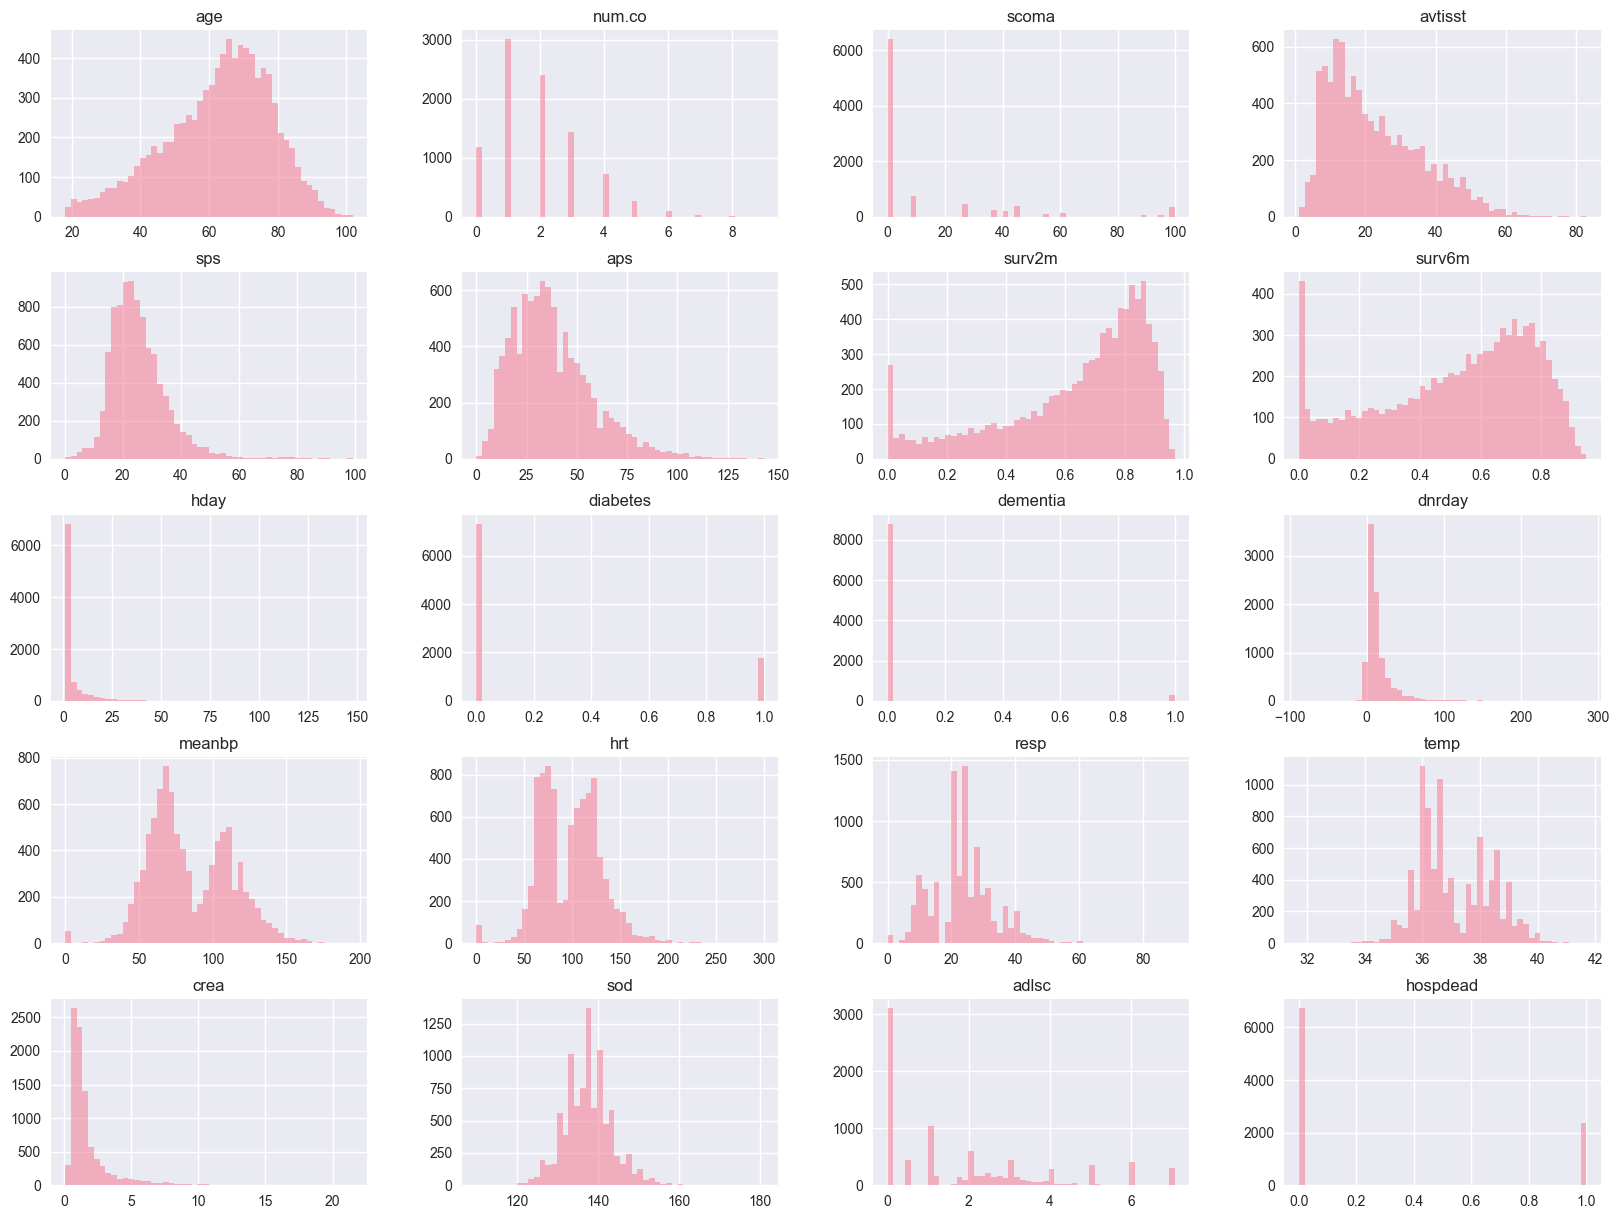

In [12]:
# Analizar la distribucion de las variables numericas

numeric_features.hist(bins=50, figsize=(20,15), alpha=0.5)
plt.show()

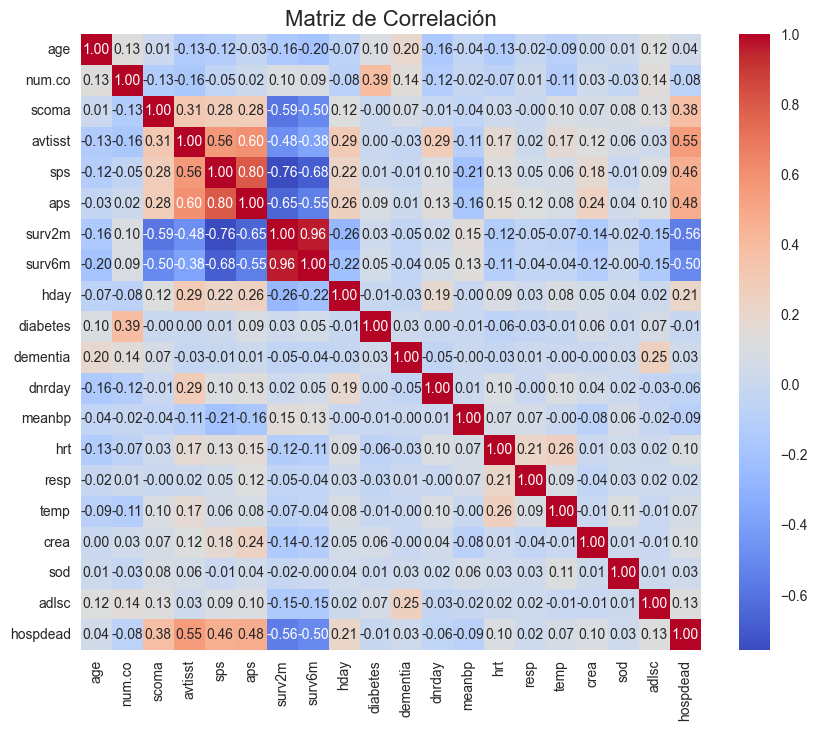

In [13]:
#Matriz de correlacion
plt.figure(figsize=(10,8))
corr_matrix = numeric_features.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

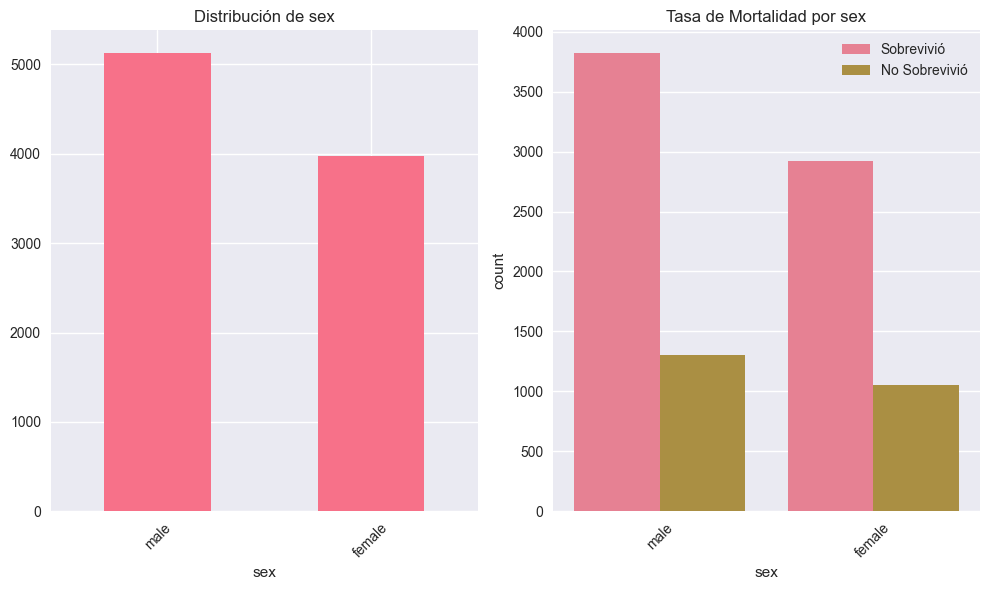

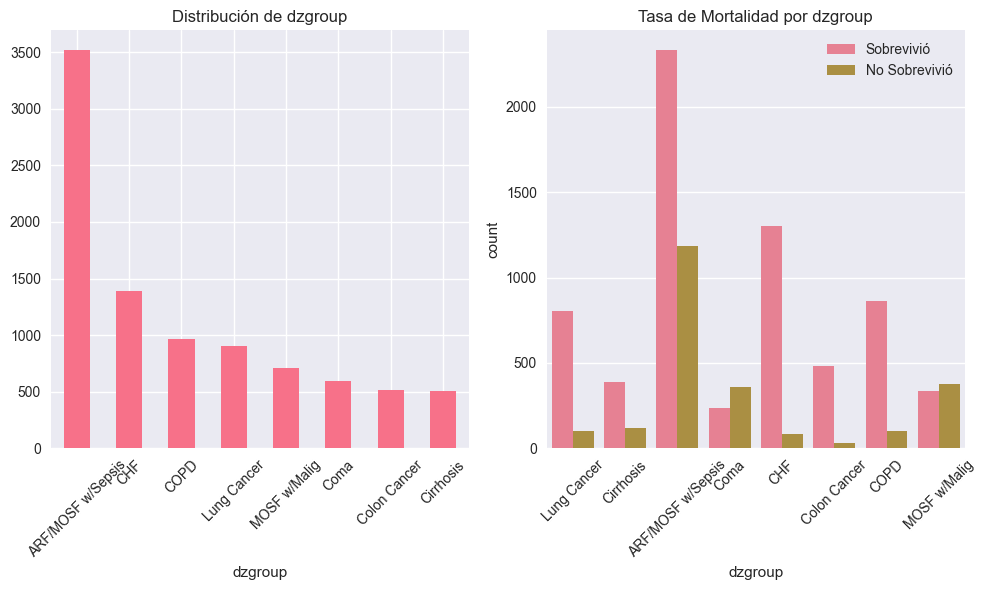

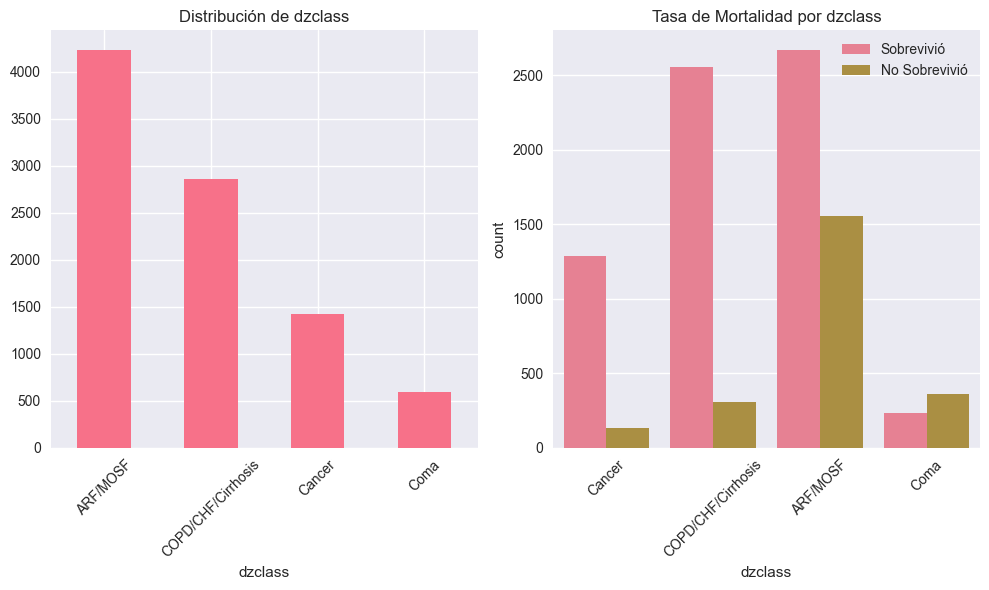

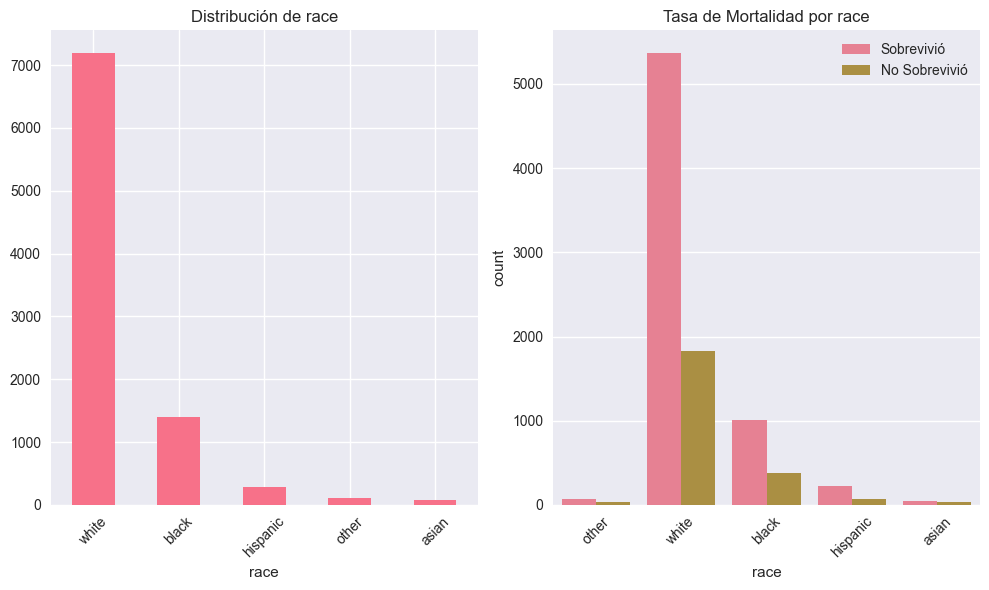

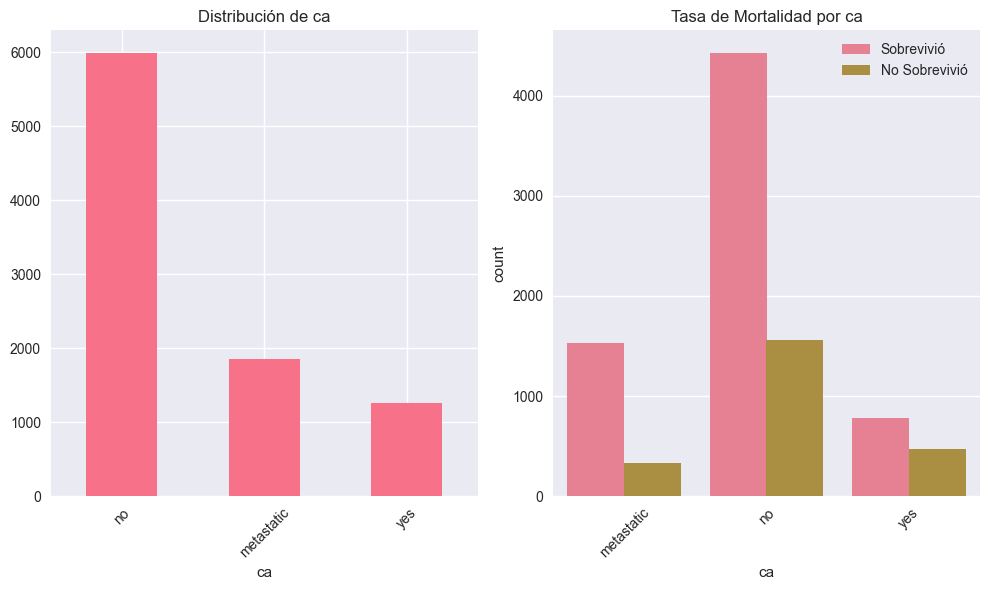

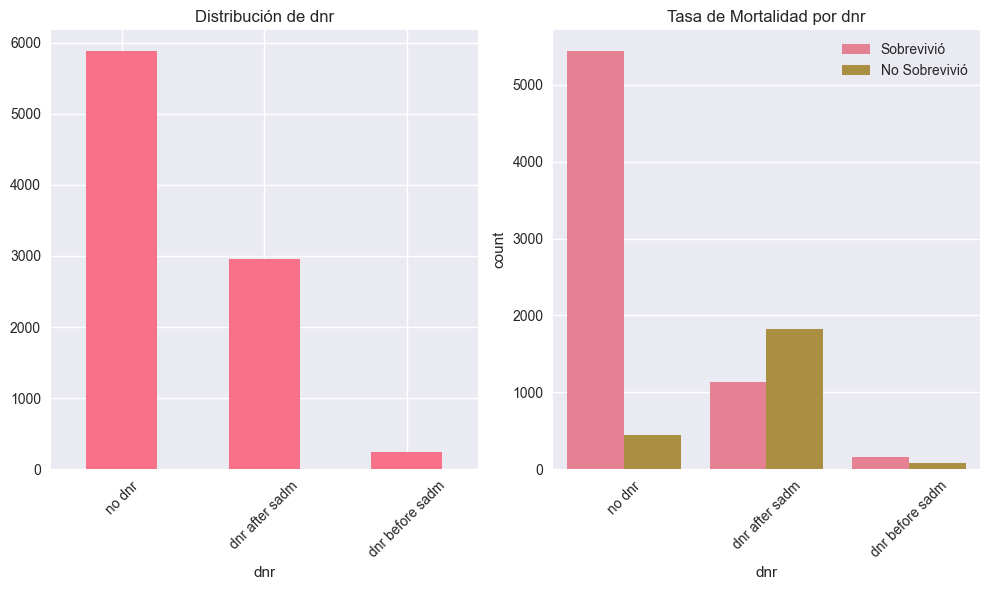

In [14]:
# Análisis de cada variable categórica
for var in categorical_features.columns:
    plt.figure(figsize=(10, 6))
    
    # Subplot 1: Distribución general
    plt.subplot(1, 2, 1)
    data[var].value_counts().plot(kind='bar')
    plt.title(f'Distribución de {var}')
    plt.xticks(rotation=45)
    
    # Subplot 2: Relación con mortalidad
    plt.subplot(1, 2, 2)
    sns.countplot(x=var, hue='hospdead', data=data, ax=plt.gca())
    plt.title(f'Tasa de Mortalidad por {var}')
    plt.xticks(rotation=45)
    plt.legend(['Sobrevivió', 'No Sobrevivió'])
    
    plt.tight_layout()
    plt.show()

In [15]:
# Detectar outliers usando IQR
def detect_outliers(df, columns):
    outlier_indices = []
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outlier_list_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.extend(outlier_list_col)
        
        print(f"{col}: {len(outlier_list_col)} outliers")
    
    return list(set(outlier_indices))

outliers = detect_outliers(data, numeric_features)
print(f"\nTotal de filas con outliers: {len(outliers)}")
print(f"Porcentaje de outliers: {len(outliers)/len(data)*100:.2f}%")

age: 56 outliers
num.co: 25 outliers
scoma: 1955 outliers
avtisst: 43 outliers
sps: 283 outliers
aps: 178 outliers
surv2m: 307 outliers
surv6m: 0 outliers
hday: 1543 outliers
diabetes: 1778 outliers
dementia: 296 outliers
dnrday: 799 outliers
meanbp: 6 outliers
hrt: 40 outliers
resp: 313 outliers
temp: 14 outliers
crea: 987 outliers
sod: 256 outliers
adlsc: 0 outliers
hospdead: 0 outliers

Total de filas con outliers: 5174
Porcentaje de outliers: 56.83%


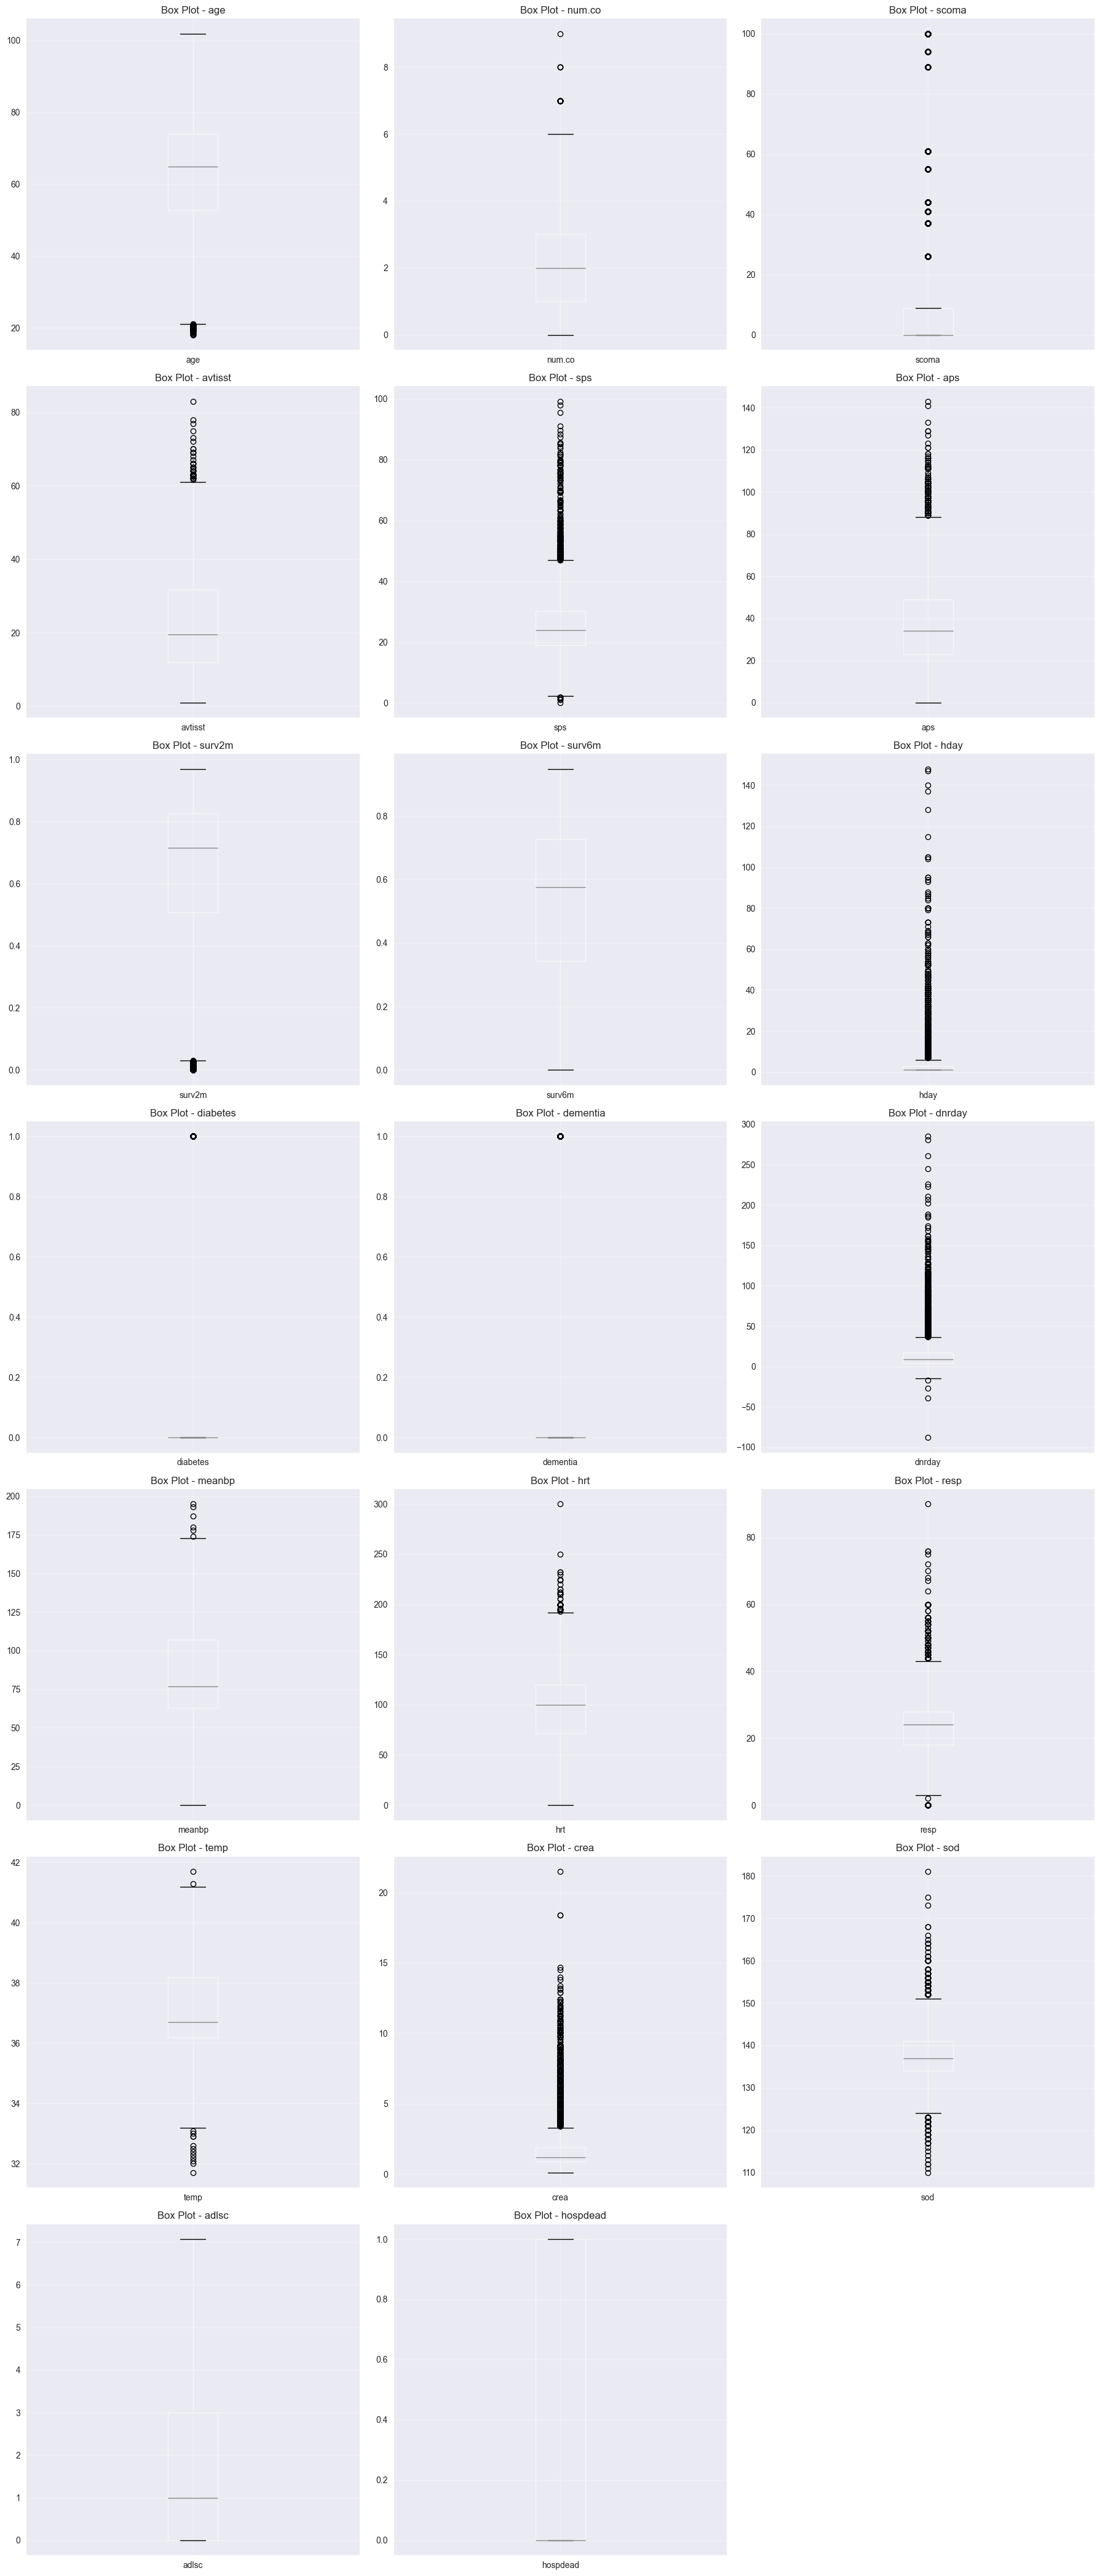

In [16]:
numeric_cols = numeric_features.columns  # Obtener los nombres de las columnas
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))

# Manejar casos donde solo hay una fila o columna
if n_rows == 1 and n_cols == 1:
    axes = [axes]
elif n_rows == 1:
    axes = axes
else:
    axes = axes.flatten()

# Crear box plots
for i, col in enumerate(numeric_cols):
    if i < len(axes):
        # Box plot básico
        data.boxplot(column=col, ax=axes[i])
        axes[i].set_title(f'Box Plot - {col}')
        axes[i].grid(True, alpha=0.3)

# Ocultar subplots vacíos
for i in range(len(numeric_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

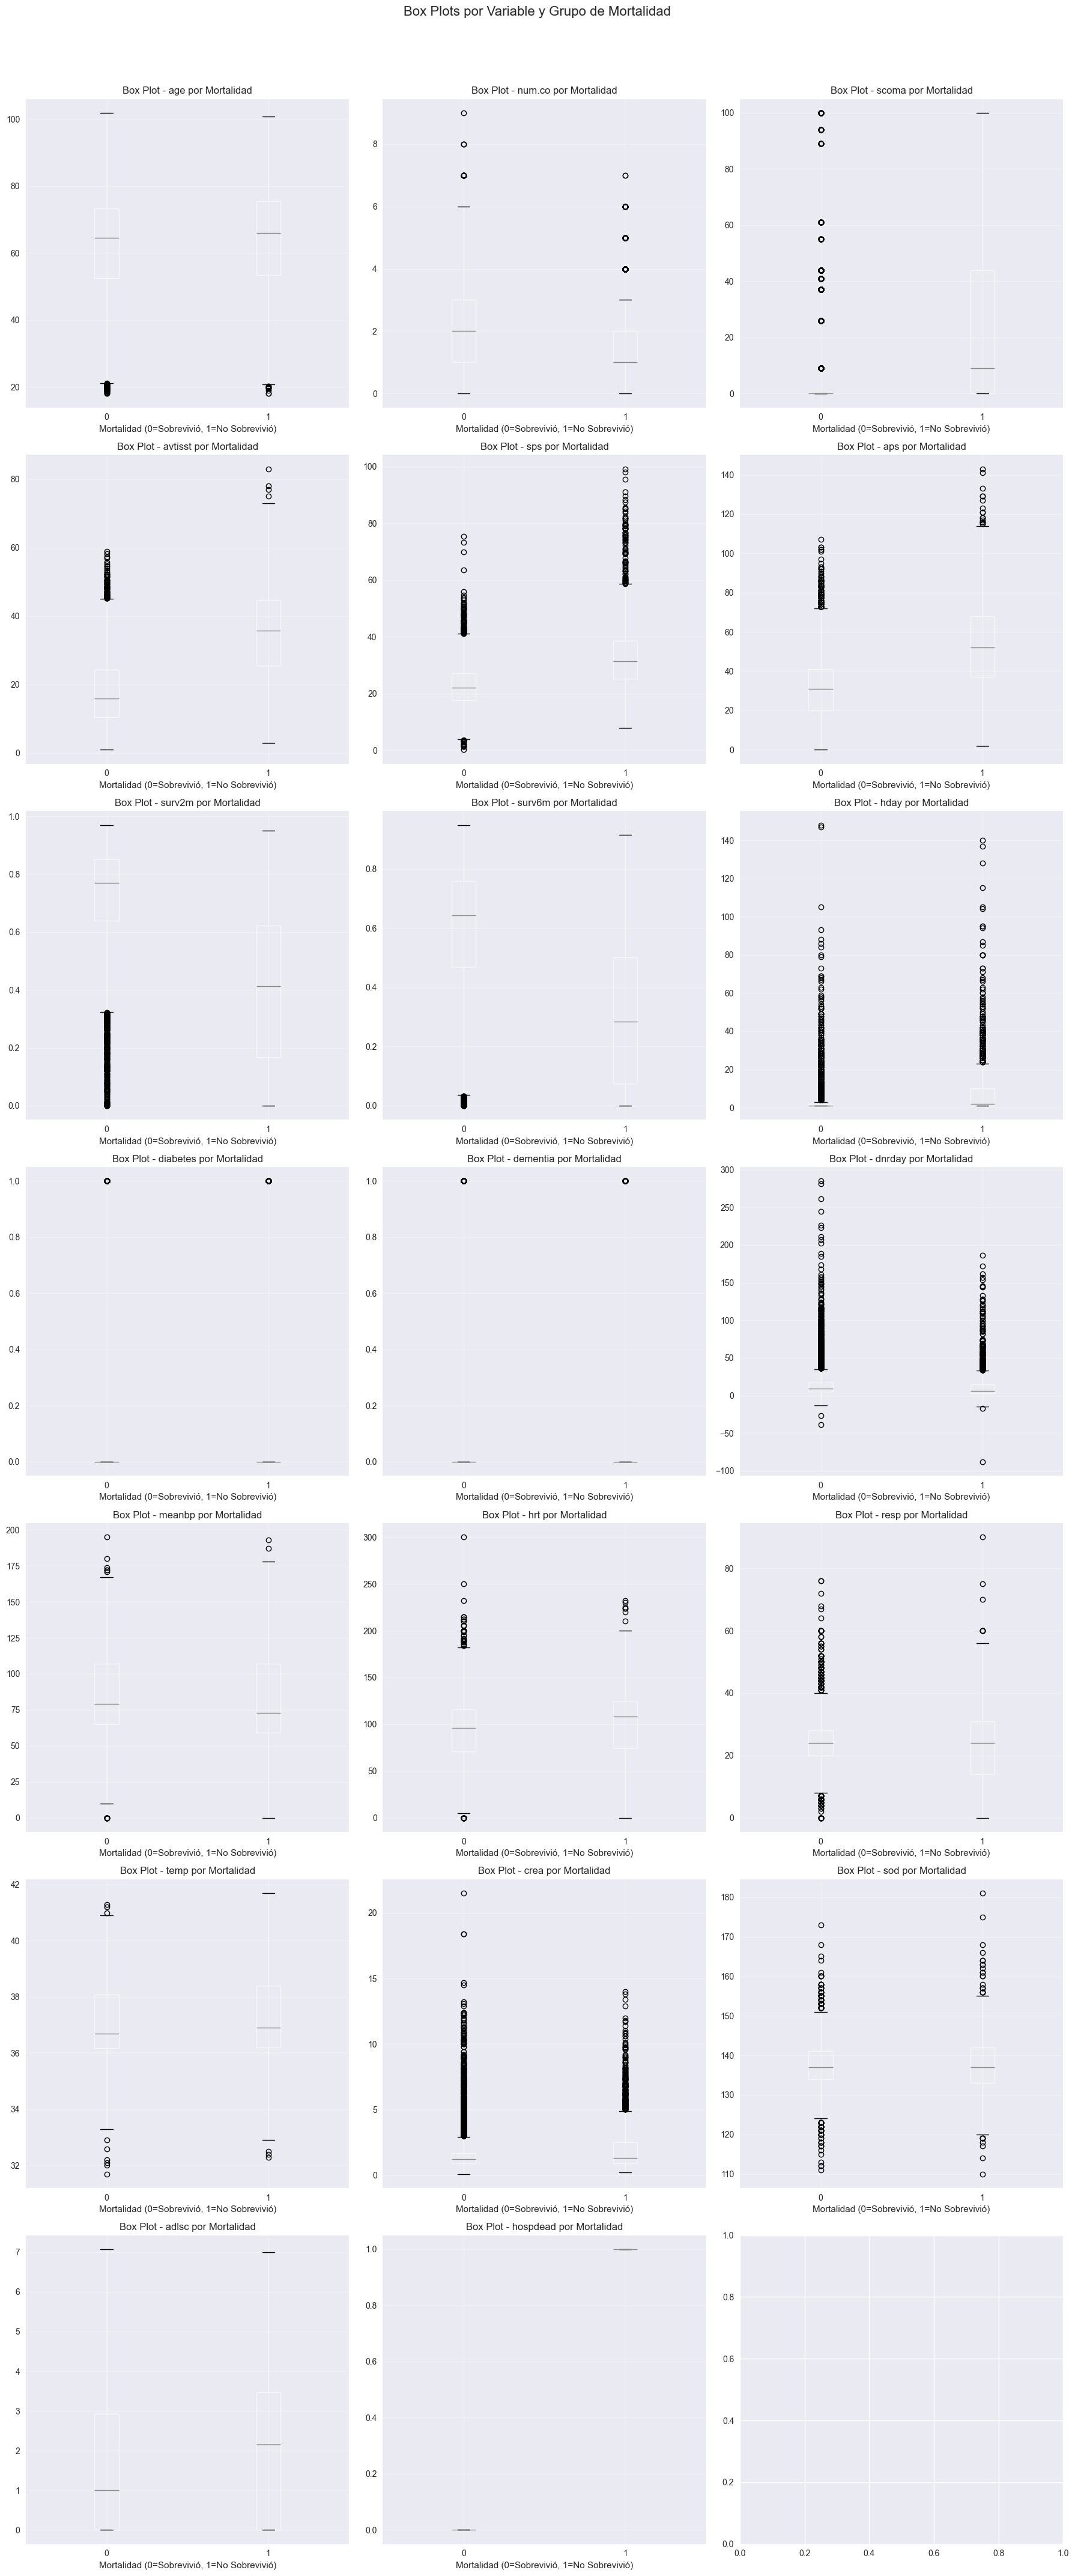

In [17]:
# Box plots comparando outliers entre grupos de mortalidad
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

for i, col in enumerate(numeric_features.columns):
    if i < len(axes):
        # Box plot por grupo de mortalidad
        data.boxplot(column=col, by='hospdead', ax=axes[i])
        axes[i].set_title(f'Box Plot - {col} por Mortalidad')
        axes[i].set_xlabel('Mortalidad (0=Sobrevivió, 1=No Sobrevivió)')
        axes[i].grid(True, alpha=0.3)

# Ocultar subplots vacíos
for i in range(len(numeric_features), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Box Plots por Variable y Grupo de Mortalidad', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

#### 4.Preparacion de los datos

In [18]:
# Separar los datos en entrenamiento y test
X = data.drop('hospdead', axis=1)
y = data['hospdead']

In [19]:
def compare_models_comprehensive(results):
    """Comparación comprehensiva de modelos"""
    
    # Extraer métricas de todos los modelos
    comparison_data = []
    for model_name, result in results.items():
        report = result['classification_report']
        comparison_data.append({
            'Modelo': model_name,
            'Accuracy': report['accuracy'],
            'Precision': report['1']['precision'],
            'Recall': report['1']['recall'],
            'F1-Score': report['1']['f1-score'],
            'Support': report['1']['support']
        })
    
    # Crear DataFrame de comparación
    df_comparison = pd.DataFrame(comparison_data)
    
    # Visualización comparativa
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Métricas principales
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange']
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        bars = ax.bar(df_comparison['Modelo'], df_comparison[metric], color=colors[i], alpha=0.7)
        ax.set_title(f'Comparación de {metric}')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        
        # Agregar valores en las barras
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Tabla resumen
    print("\n=== COMPARACIÓN DE MODELOS ===")
    print(df_comparison.round(4).to_string(index=False))
    
    # Recomendación
    best_recall = df_comparison.loc[df_comparison['Recall'].idxmax()]
    best_f1 = df_comparison.loc[df_comparison['F1-Score'].idxmax()]
    
    print(f"\n=== RECOMENDACIONES ===")
    print(f"Mejor Recall (detectar muertes): {best_recall['Modelo']} ({best_recall['Recall']:.3f})")
    print(f"Mejor F1-Score (balance): {best_f1['Modelo']} ({best_f1['F1-Score']:.3f})")
    
    return df_comparison

In [66]:
def evaluate_model_comprehensive(model, X_test, y_test, model_name="Modelo"):
    """Evaluación comprehensiva del modelo"""
    
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Métricas básicas
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'avg_precision': average_precision_score(y_test, y_pred_proba)
    }
    
    # Crear subplot de métricas
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Matriz de confusión mejorada
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
    axes[0,0].set_title(f'Matriz de Confusión - {model_name}')
    axes[0,0].set_xlabel('Predicción')
    axes[0,0].set_ylabel('Real')
    
    # Interpretar matriz de confusión
    tn, fp, fn, tp = cm.ravel()
    axes[0,0].text(0.5, -0.1, f'TN:{tn} FP:{fp}\nFN:{fn} TP:{tp}', 
                   transform=axes[0,0].transAxes, ha='center')
    
    # 2. Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[0,1].plot(fpr, tpr, label=f'ROC AUC = {metrics["roc_auc"]:.3f}')
    axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.6)
    axes[0,1].set_xlabel('Tasa de Falsos Positivos')
    axes[0,1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[0,1].set_title('Curva ROC')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Curva Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    axes[1,0].plot(recall, precision, label=f'AP = {metrics["avg_precision"]:.3f}')
    axes[1,0].set_xlabel('Recall')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].set_title('Curva Precision-Recall')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    #plt.subplot(2, 2, 3)
    from sklearn.calibration import calibration_curve
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)
    axes[1,1].plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
    axes[1,1].plot([0, 1], [0, 1], "k:", label="Perfectamente calibrado")
    axes[1,1].set_xlabel('Probabilidad Media Predicha')
    axes[1,1].set_ylabel('Fracción de Positivos')
    axes[1,1].set_title('Curva de Calibración')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # 4. Distribución de probabilidades
    #axes[1,1].hist(y_pred_proba[y_test==0], alpha=0.6, label='Clase 0', bins=30)
    #axes[1,1].hist(y_pred_proba[y_test==1], alpha=0.6, label='Clase 1', bins=30)
    #axes[1,1].set_xlabel('Probabilidad Predicha')
    #axes[1,1].set_ylabel('Frecuencia')
    #axes[1,1].set_title('Distribución de Probabilidades')
    #axes[1,1].legend()
    #axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar métricas
    print(f"\n=== MÉTRICAS PARA {model_name.upper()} ===")
    for metric, value in metrics.items():
        print(f"{metric.upper()}: {value:.4f}")
    
    # Interpretación específica para mortalidad
    print(f"\n=== INTERPRETACIÓN CLÍNICA ===")
    print(f"Sensibilidad (Detectar muertes): {metrics['recall']:.1%}")
    print(f"Especificidad (Detectar supervivencia): {tn/(tn+fp):.1%}")
    print(f"Falsos Negativos (Muertes no detectadas): {fn} casos ")
    print(f"Falsos Positivos (Falsas alarmas): {fp} casos")
    
    return metrics

In [67]:
def train_models(X_train, y_train, X_test, y_test, models, param_grids):
    results = {}
    scoring = ['precision', 'recall', 'f1', 'roc_auc']
    for model_name, model in models.items():
        print(f"\nEntrenando modelo: {model_name}")
        
        # Obtener el espacio de hiperparámetros
        param_grid = param_grids.get(model_name, {})
        
        # Configurar búsqueda aleatoria con validación cruzada estratificada
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
        random_search = RandomizedSearchCV(estimator=model,
                                           param_distributions=param_grid,
                                           n_iter=20,
                                           scoring=scoring,
                                           refit='recall',
                                           n_jobs=-1,
                                           cv=cv,
                                           verbose=1,
                                           random_state=42)
        
        # Entrenar el modelo
        random_search.fit(X_train, y_train)
        
        # Mejor modelo
        best_model = random_search.best_estimator_
        print(f"Mejores hiperparámetros: {random_search.best_params_}")
        
        # Evaluar en conjunto de prueba
        y_pred = best_model.predict(X_test)
        
        # Fix: Call evaluate_model_comprehensive with correct parameters
        metrics = evaluate_model_comprehensive(best_model, X_test, y_test, model_name=model_name)
        
        # Reporte de clasificación
        report = classification_report(y_test, y_pred, output_dict=True)
        print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))
        
        # Guardar resultados
        results[model_name] = {
            'best_model': best_model,
            'metrics': metrics,  # Store the returned metrics
            'classification_report': report
        }
    
    return results

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [69]:
# Fix: Get column names from X_train (not from the original data with target)
numeric_features_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()


#Pipeline para caracteristicas numericas
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

#Pipeline para caracterisitcas categoricas
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features_cols),
        ('cat', cat_transformer, categorical_features_cols)
    ]
)

#### 5. Busqueda de hiperparametros

In [70]:
# Pipeline con Random Forest
rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, n_estimators=100))
])

# Pipeline con XGBoost
xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(random_state=42))
])

# Pipeline con SVM
svm_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', SVC(random_state=42, probability=True))
])
# Pipeline con Regresion Logistica
logreg_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(random_state=42))
])

# Pipeline con LightGBM
lgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    #('smote', SMOTE(random_state=42)),
    ('clf', LGBMClassifier(random_state=42, verbosity=-1, boosting_type='gbdt',
                           objective='binary', metric='binary_logloss', class_weight='balanced'))
])



In [71]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
rf_class_weights = {0: 1.0, 1: scale_pos_weight}
param_dist_lr = {
    'clf__C': np.logspace(-3, 2, 10), # From regularized to non-regularized
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga'],
    'clf__class_weight': [None, 'balanced']
}

param_dist_rf = {
    'clf__n_estimators': np.arange(100, 1000, 100),
    'clf__max_depth': np.arange(5, 21, 2),
    'clf__min_samples_split': np.arange(2, 21, 2),
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__class_weight': [None, rf_class_weights]
}

param_dist_xgb = {
    'clf__n_estimators': np.arange(100, 501, 50),
    'clf__max_depth': np.arange(3, 11, 1),
    'clf__learning_rate': np.linspace(0.01, 0.3, 10),
    'clf__reg_alpha': np.logspace(-3, 1, 10),
    'clf__reg_lambda': np.logspace(-3, 1, 10),
    'clf__scale_pos_weight': [1, scale_pos_weight]
}


param_dist_svm = {
    'clf__C': np.logspace(-3, 2, 10),
    'clf__kernel': ['linear', 'rbf', 'poly'],
    'clf__degree': np.arange(2, 5),
    'clf__gamma': ['scale', 'auto'],
    'clf__class_weight': [None, 'balanced']
}

# Hiperparámetros para LightGBM
param_dist_lgb = {
    'clf__n_estimators': np.arange(100, 501, 50),
    'clf__max_depth': np.arange(3, 10, 1),
    'clf__learning_rate': np.linspace(0.01, 0.3, 10),
    #'clf__num_leaves': np.arange(10, 100, 10),
    #'clf__feature_fraction': np.linspace(0.6, 1.0, 5),
    #'clf__bagging_fraction': np.linspace(0.6, 1.0, 5)
}

#crear dict con los modelos y sus parametros y el pipeline de preprocesamiento

models = {
    "Logistic Regression": logreg_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline,
    "LightGBM": lgb_pipeline
    #"SVM": svm_pipeline
}

param_dist = {
    "Logistic Regression": param_dist_lr,
    "Random Forest": param_dist_rf,
    "XGBoost": param_dist_xgb,
    #"LightGBM": param_dist_lgb
    #"SVM": param_dist_svm
}

In [72]:
# Configurar StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Entrenando modelo: Logistic Regression
Fitting 15 folds for each of 20 candidates, totalling 300 fits
Mejores hiperparámetros: {'clf__solver': 'saga', 'clf__penalty': 'l2', 'clf__class_weight': None, 'clf__C': np.float64(0.1668100537200059)}


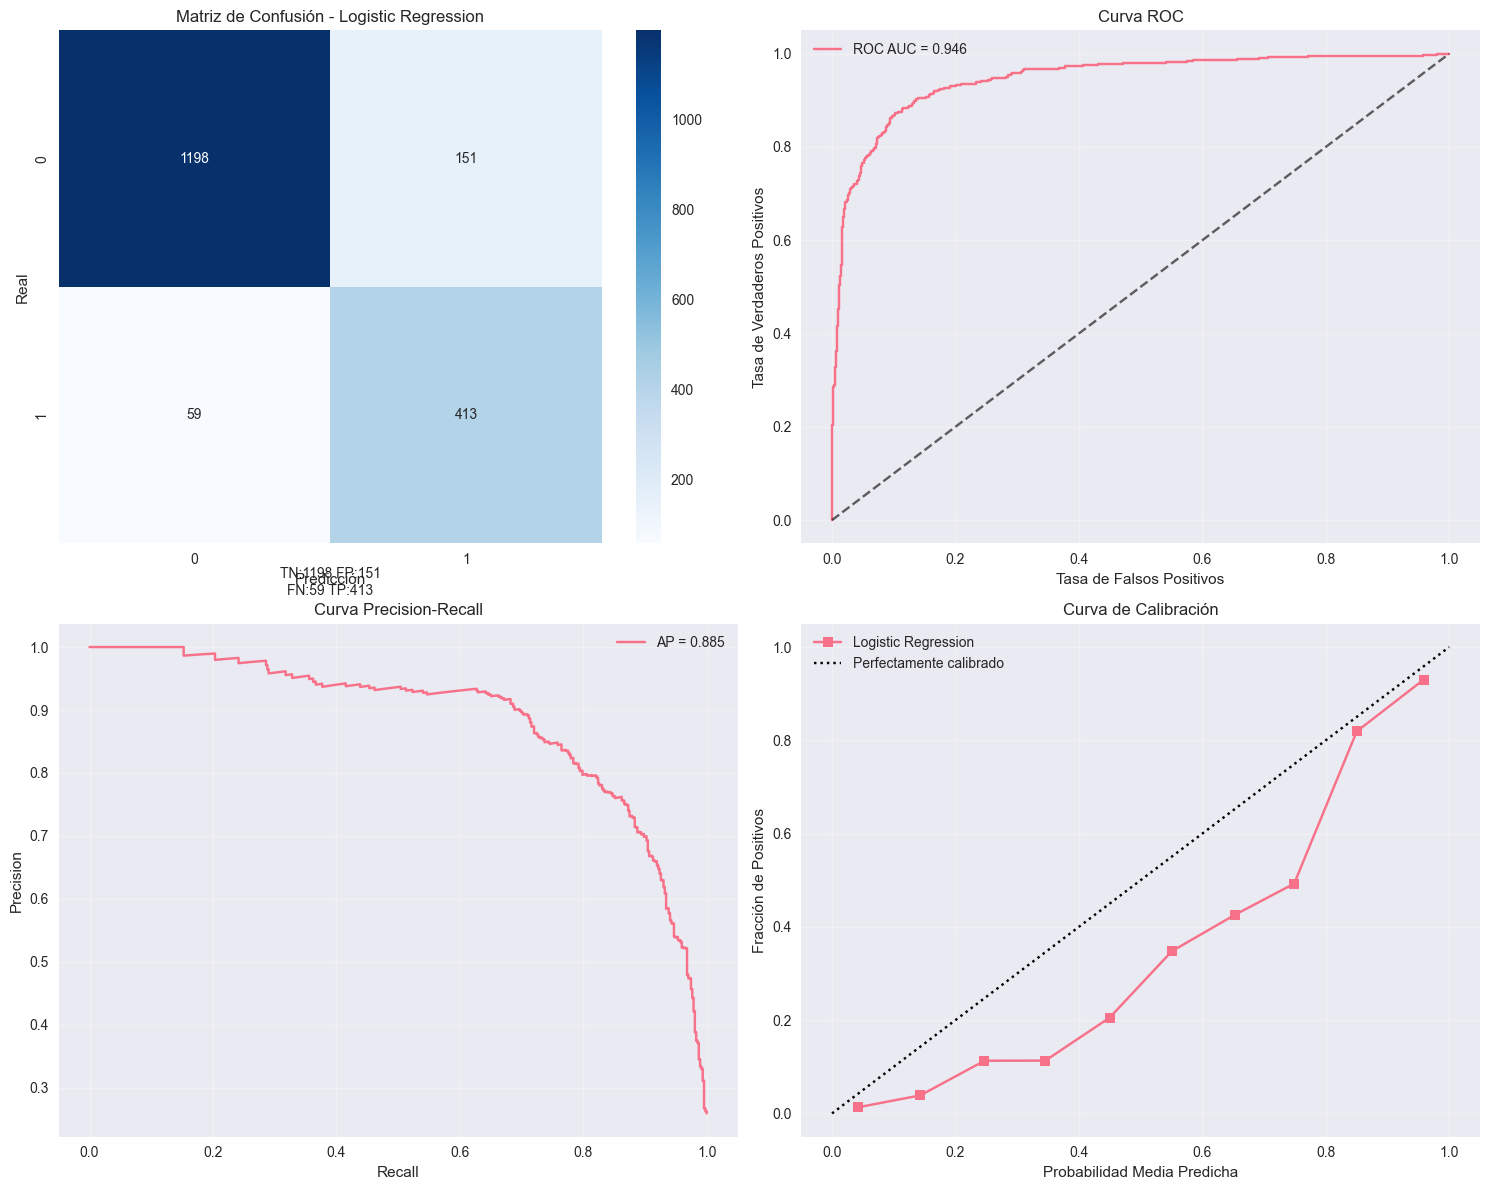


=== MÉTRICAS PARA LOGISTIC REGRESSION ===
ACCURACY: 0.8847
PRECISION: 0.7323
RECALL: 0.8750
F1: 0.7973
ROC_AUC: 0.9463
AVG_PRECISION: 0.8850

=== INTERPRETACIÓN CLÍNICA ===
Sensibilidad (Detectar muertes): 87.5%
Especificidad (Detectar supervivencia): 88.8%
Falsos Negativos (Muertes no detectadas): 59 casos 
Falsos Positivos (Falsas alarmas): 151 casos

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.95      0.89      0.92      1349
           1       0.73      0.88      0.80       472

    accuracy                           0.88      1821
   macro avg       0.84      0.88      0.86      1821
weighted avg       0.90      0.88      0.89      1821


Entrenando modelo: Random Forest
Fitting 15 folds for each of 20 candidates, totalling 300 fits
Mejores hiperparámetros: {'clf__n_estimators': np.int64(300), 'clf__min_samples_split': np.int64(10), 'clf__max_features': 'log2', 'clf__max_depth': np.int64(7), 'clf__class_weight': {0: 1.0, 

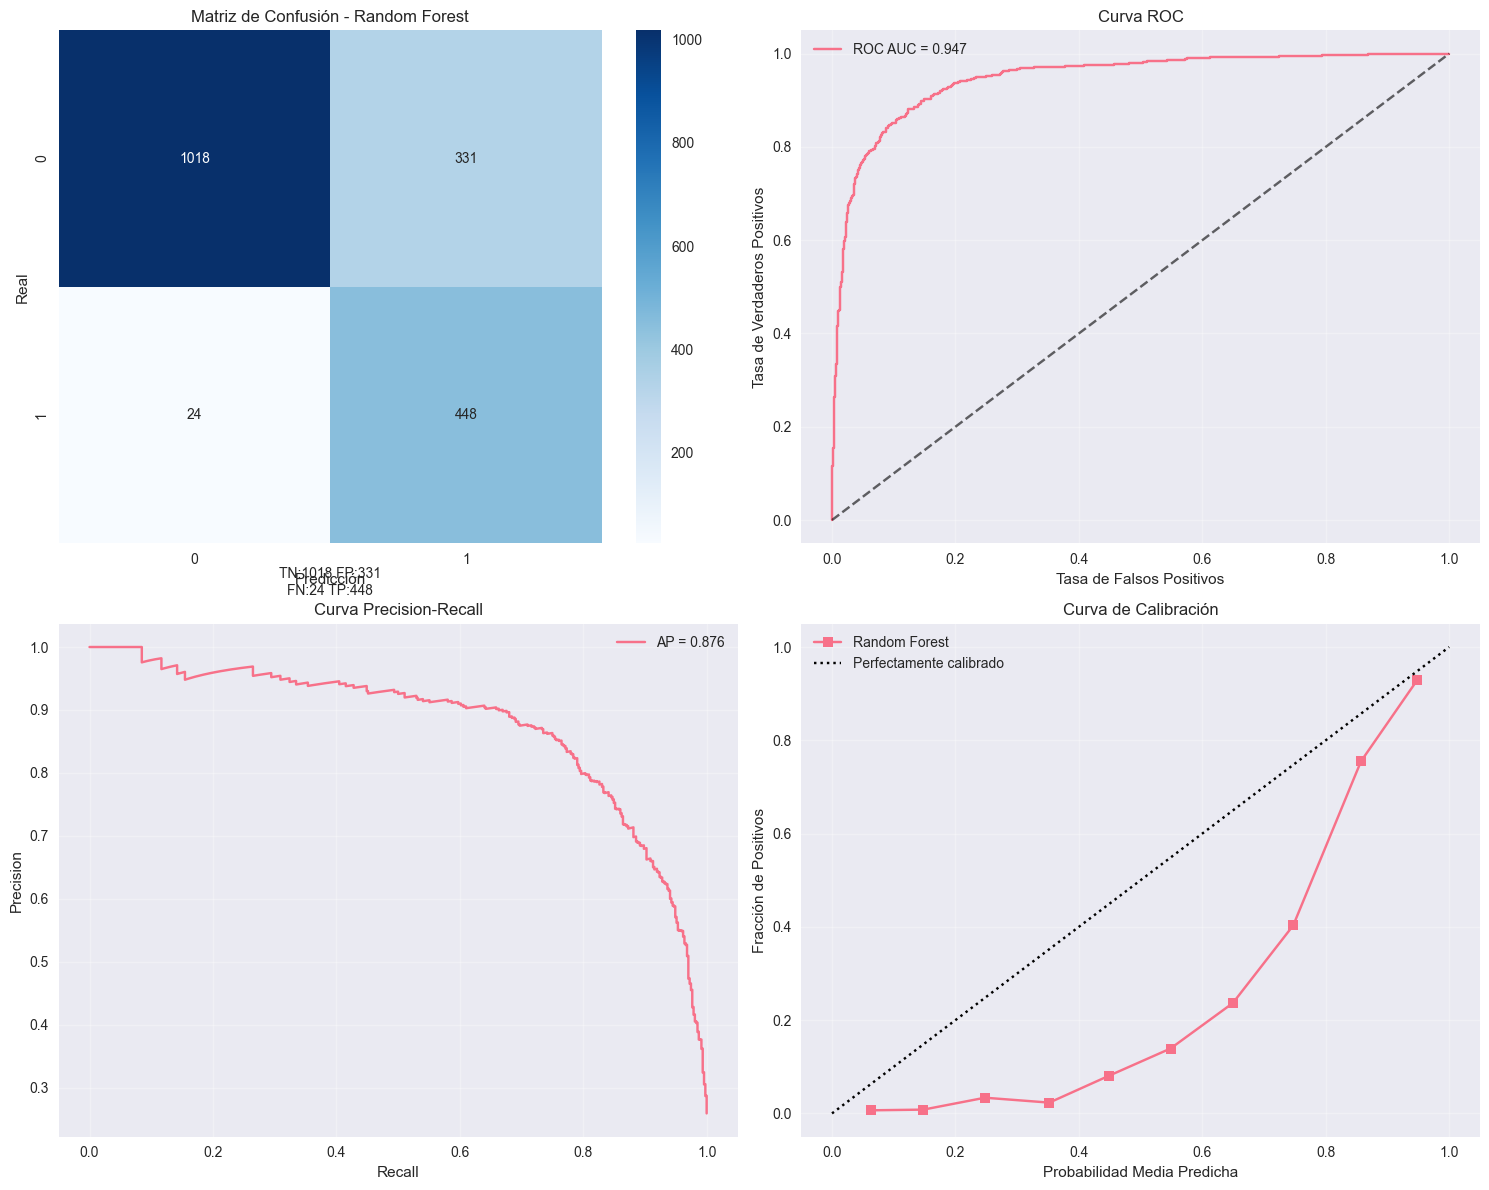


=== MÉTRICAS PARA RANDOM FOREST ===
ACCURACY: 0.8051
PRECISION: 0.5751
RECALL: 0.9492
F1: 0.7162
ROC_AUC: 0.9467
AVG_PRECISION: 0.8759

=== INTERPRETACIÓN CLÍNICA ===
Sensibilidad (Detectar muertes): 94.9%
Especificidad (Detectar supervivencia): 75.5%
Falsos Negativos (Muertes no detectadas): 24 casos 
Falsos Positivos (Falsas alarmas): 331 casos

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85      1349
           1       0.58      0.95      0.72       472

    accuracy                           0.81      1821
   macro avg       0.78      0.85      0.78      1821
weighted avg       0.87      0.81      0.82      1821


Entrenando modelo: XGBoost
Fitting 15 folds for each of 20 candidates, totalling 300 fits
Mejores hiperparámetros: {'clf__scale_pos_weight': np.float64(2.858050847457627), 'clf__reg_lambda': np.float64(0.05994842503189409), 'clf__reg_alpha': np.float64(3.593813663804626), 'clf__n_estimators': 

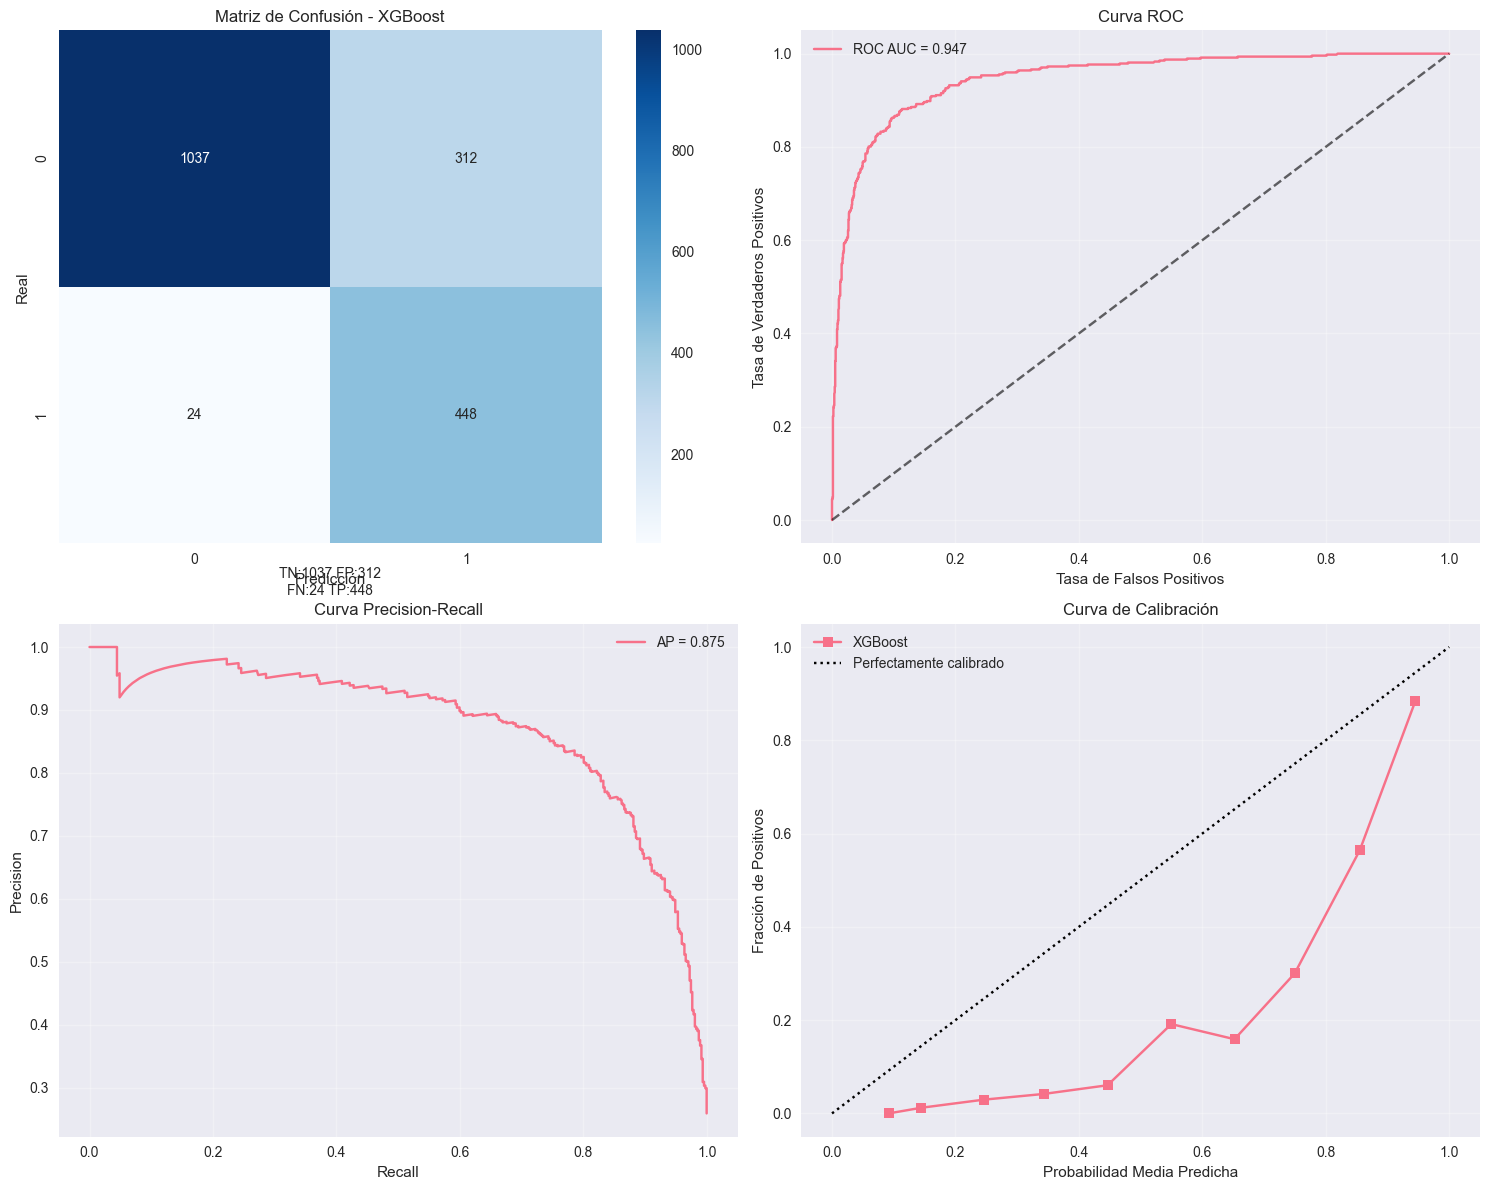


=== MÉTRICAS PARA XGBOOST ===
ACCURACY: 0.8155
PRECISION: 0.5895
RECALL: 0.9492
F1: 0.7273
ROC_AUC: 0.9466
AVG_PRECISION: 0.8754

=== INTERPRETACIÓN CLÍNICA ===
Sensibilidad (Detectar muertes): 94.9%
Especificidad (Detectar supervivencia): 76.9%
Falsos Negativos (Muertes no detectadas): 24 casos 
Falsos Positivos (Falsas alarmas): 312 casos

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.98      0.77      0.86      1349
           1       0.59      0.95      0.73       472

    accuracy                           0.82      1821
   macro avg       0.78      0.86      0.79      1821
weighted avg       0.88      0.82      0.83      1821


Entrenando modelo: LightGBM
Fitting 15 folds for each of 1 candidates, totalling 15 fits
Mejores hiperparámetros: {}


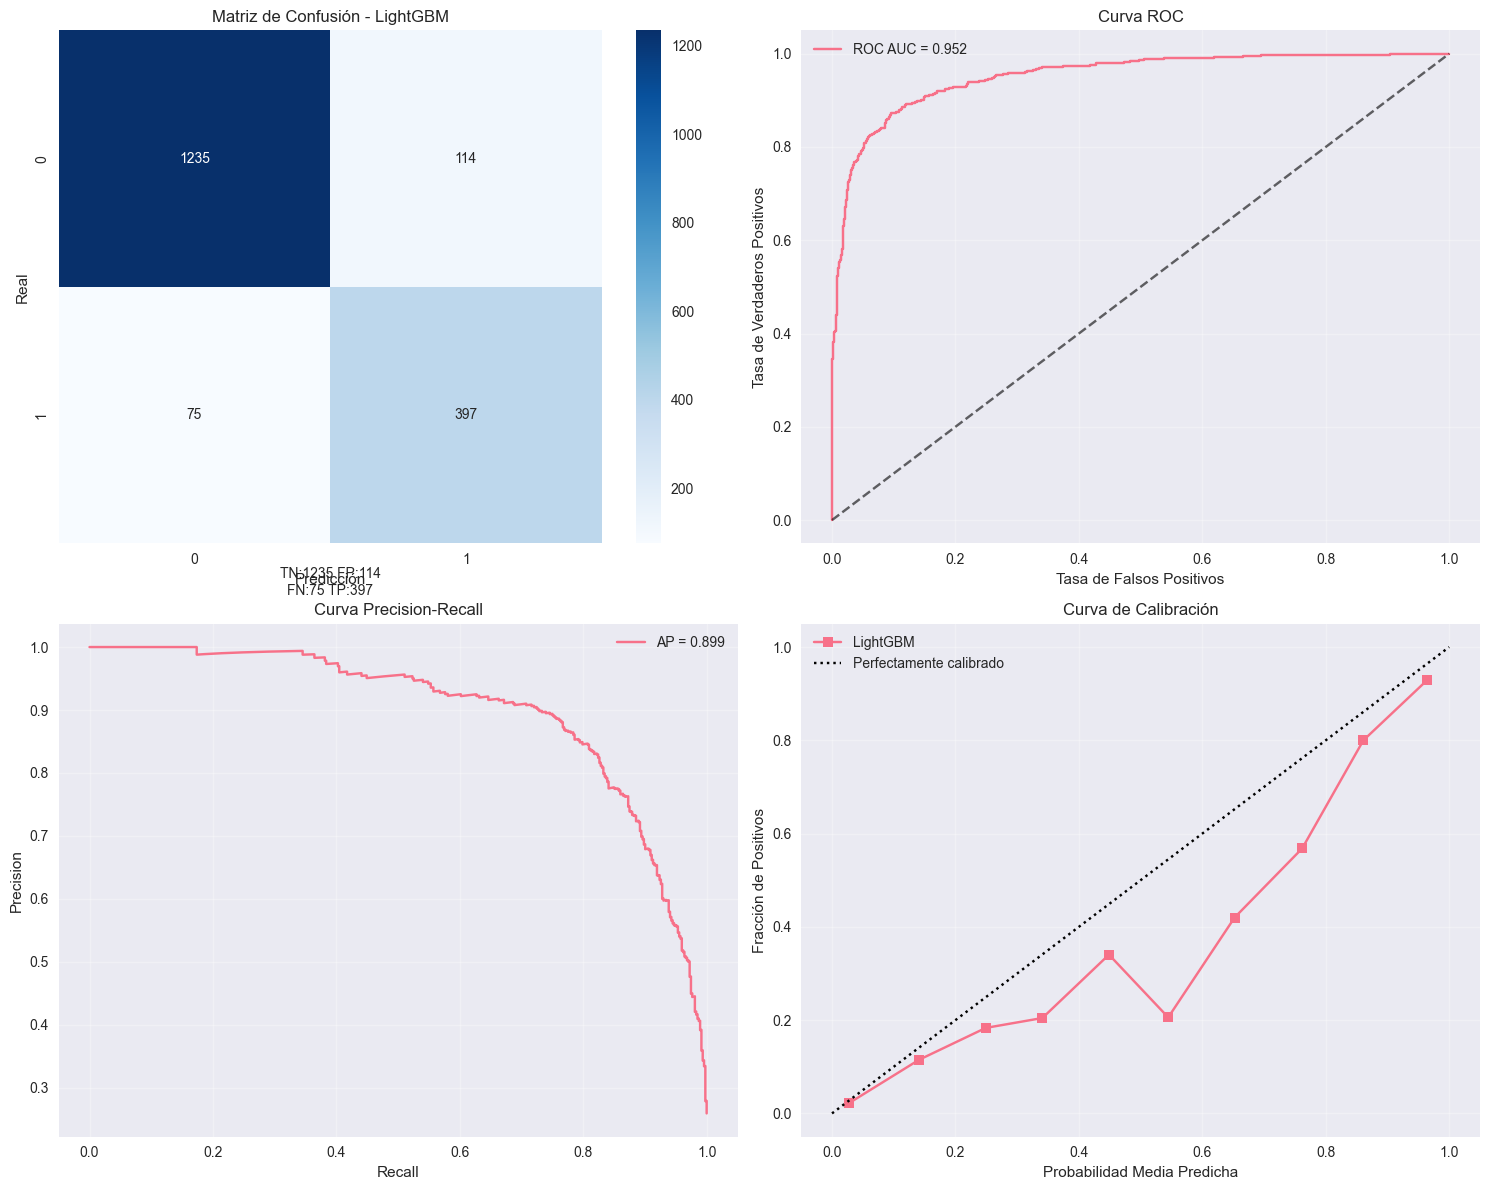


=== MÉTRICAS PARA LIGHTGBM ===
ACCURACY: 0.8962
PRECISION: 0.7769
RECALL: 0.8411
F1: 0.8077
ROC_AUC: 0.9520
AVG_PRECISION: 0.8994

=== INTERPRETACIÓN CLÍNICA ===
Sensibilidad (Detectar muertes): 84.1%
Especificidad (Detectar supervivencia): 91.5%
Falsos Negativos (Muertes no detectadas): 75 casos 
Falsos Positivos (Falsas alarmas): 114 casos

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1349
           1       0.78      0.84      0.81       472

    accuracy                           0.90      1821
   macro avg       0.86      0.88      0.87      1821
weighted avg       0.90      0.90      0.90      1821



In [73]:
results = train_models(X_train, y_train, X_test, y_test, models, param_dist)

Implemetar pesos para el mejor modelo

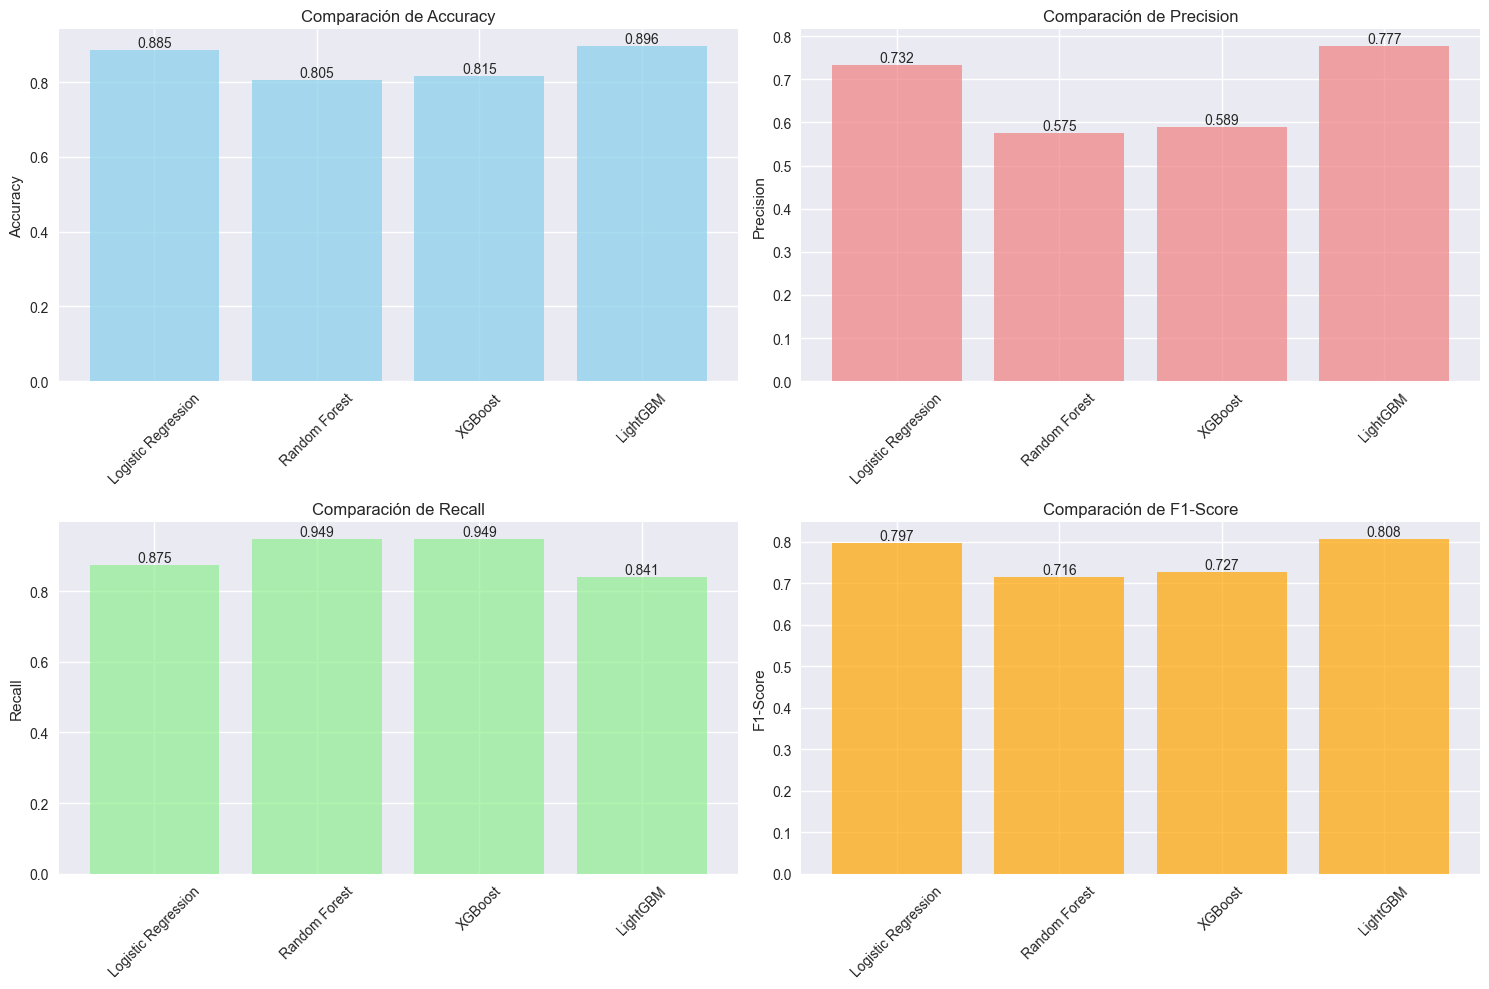


=== COMPARACIÓN DE MODELOS ===
             Modelo  Accuracy  Precision  Recall  F1-Score  Support
Logistic Regression    0.8847     0.7323  0.8750    0.7973    472.0
      Random Forest    0.8051     0.5751  0.9492    0.7162    472.0
            XGBoost    0.8155     0.5895  0.9492    0.7273    472.0
           LightGBM    0.8962     0.7769  0.8411    0.8077    472.0

=== RECOMENDACIONES ===
Mejor Recall (detectar muertes): Random Forest (0.949)
Mejor F1-Score (balance): LightGBM (0.808)


In [74]:
# Agregar después de train_models
model_comparison = compare_models_comprehensive(results)

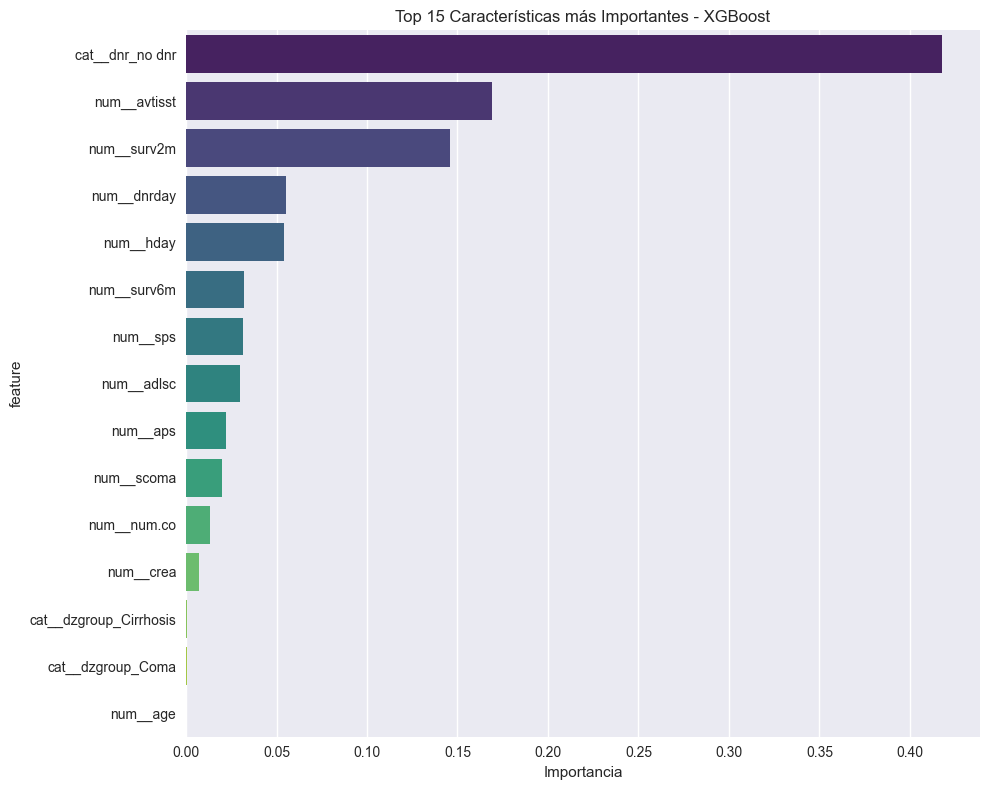


Top 10 características más importantes para XGBoost:
        feature  importance
cat__dnr_no dnr    0.417835
   num__avtisst    0.169338
    num__surv2m    0.145613
    num__dnrday    0.055480
      num__hday    0.054386
    num__surv6m    0.032189
       num__sps    0.031209
     num__adlsc    0.030012
       num__aps    0.022272
     num__scoma    0.020099


In [75]:
def analyze_feature_importance(best_model, feature_names, model_name):
    """Análisis de importancia de características"""
    
    # Obtener el clasificador del pipeline
    if hasattr(best_model, 'named_steps'):
        clf = best_model.named_steps['clf']
    else:
        clf = best_model
    
    # Extraer importancias según el tipo de modelo
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        importances = np.abs(clf.coef_[0])
    else:
        print(f"No se pueden extraer importancias para {model_name}")
        return
    
    # Crear DataFrame de importancias
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Visualizar top 15 features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance_df.head(15)
    sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
    plt.title(f'Top 15 Características más Importantes - {model_name}')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop 10 características más importantes para {model_name}:")
    print(feature_importance_df.head(10).to_string(index=False))
    
    return feature_importance_df

# Para el mejor modelo (ejemplo XGBoost)
if 'XGBoost' in results:
    X_train_processed = results['XGBoost']['best_model'].named_steps['preprocessor'].fit_transform(X_train)
    feature_names = results['XGBoost']['best_model'].named_steps['preprocessor'].get_feature_names_out()
    
    importance_df = analyze_feature_importance(
        results['XGBoost']['best_model'], 
        feature_names, 
        'XGBoost'
    )